In [13]:
#Importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, concatenate)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [47]:
#Loading Dataset
ppg_bp_path = 'PPG-BP dataset.xlsx'
table1_path = 'Table 1.xlsx'

ppg_bp_data = pd.ExcelFile(ppg_bp_path)
table1_data = pd.ExcelFile(table1_path)

ppg_bp_data.sheet_names, table1_data.sheet_names


(['cardiovascular dataset'], ['Table 1'])

In [48]:
ppg_bp_df = ppg_bp_data.parse('cardiovascular dataset')
table1_df = table1_data.parse('Table 1')

ppg_bp_df.head(), table1_df.head()

(  Cardiovascular Dataset Information File  Unnamed: 1 Unnamed: 2 Unnamed: 3  \
 0                                    Num.  subject_ID   Sex(M/F)  Age(year)   
 1                                       1           2     Female         45   
 2                                       2           3     Female         50   
 3                                       3           6     Female         47   
 4                                       4           8       Male         45   
 
    Unnamed: 4  Unnamed: 5                     Unnamed: 6  \
 0  Height(cm)  Weight(kg)  Systolic Blood Pressure(mmHg)   
 1         152          63                            161   
 2         157          50                            160   
 3         150          47                            101   
 4         172          65                            136   
 
                        Unnamed: 7       Unnamed: 8   Unnamed: 9  \
 0  Diastolic Blood Pressure(mmHg)  Heart Rate(b/m)  BMI(kg/m^2)   
 1            

In [49]:
#Cleaning the data
ppg_bp_df.columns = ppg_bp_df.iloc[0]
ppg_bp_df = ppg_bp_df[1:]
ppg_bp_df.columns = ppg_bp_df.columns.str.strip()

ppg_bp_df.head(), ppg_bp_df.dtypes

(0 Num. subject_ID Sex(M/F) Age(year) Height(cm) Weight(kg)  \
 1    1          2   Female        45        152         63   
 2    2          3   Female        50        157         50   
 3    3          6   Female        47        150         47   
 4    4          8     Male        45        172         65   
 5    5          9   Female        46        155         65   
 
 0 Systolic Blood Pressure(mmHg) Diastolic Blood Pressure(mmHg)  \
 1                           161                             89   
 2                           160                             93   
 3                           101                             71   
 4                           136                             93   
 5                           123                             73   
 
 0 Heart Rate(b/m) BMI(kg/m^2)          Hypertension Diabetes  \
 1              97   27.268006  Stage 2 hypertension      NaN   
 2              76   20.284799  Stage 2 hypertension      NaN   
 3              79   

In [50]:
#Converting the columns to numeric values 
columns_to_numeric = [
    "Age(year)", "Height(cm)", "Weight(kg)", "Systolic Blood Pressure(mmHg)",
    "Diastolic Blood Pressure(mmHg)", "Heart Rate(b/m)", "BMI(kg/m^2)"
]
ppg_bp_df[columns_to_numeric] = ppg_bp_df[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

# Checking for missing values
ppg_bp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 1 to 219
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Num.                            219 non-null    object 
 1   subject_ID                      219 non-null    object 
 2   Sex(M/F)                        219 non-null    object 
 3   Age(year)                       219 non-null    int64  
 4   Height(cm)                      219 non-null    int64  
 5   Weight(kg)                      219 non-null    int64  
 6   Systolic Blood Pressure(mmHg)   219 non-null    int64  
 7   Diastolic Blood Pressure(mmHg)  219 non-null    int64  
 8   Heart Rate(b/m)                 219 non-null    int64  
 9   BMI(kg/m^2)                     219 non-null    float64
 10  Hypertension                    219 non-null    object 
 11  Diabetes                        38 non-null     object 
 12  cerebral infarction             20 n

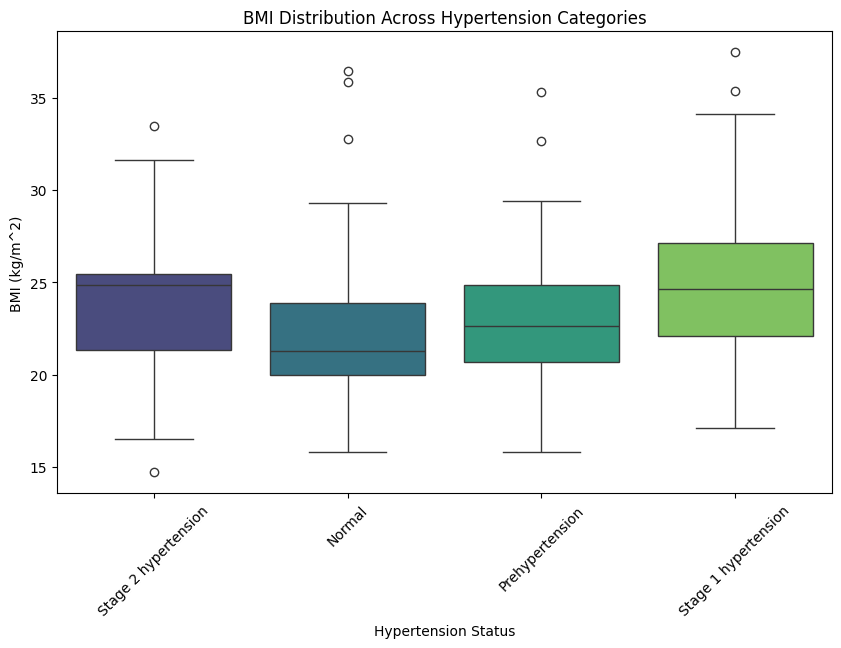

In [31]:
ppg_bp_df['Hypertension'] = ppg_bp_df['Hypertension'].fillna('Normal')

#BMI vs Hypertension Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=ppg_bp_df, x='Hypertension', y='BMI(kg/m^2)', hue='Hypertension', palette='viridis', legend=False)
plt.title('BMI Distribution Across Hypertension Categories')
plt.xlabel('Hypertension Status')
plt.ylabel('BMI (kg/m^2)')
plt.xticks(rotation=45)
plt.show()


This BMI vs Hypertension plot reveals a positive correlation between BMI and the severity of hypertension. Individuals with higher BMIs are more likely to have severe hypertension i.e Stage 2 hypertension, while those with lower BMIs are generally in the normal or prehypertensive categories. This highlights that obesity plays an important role in cardiovascular health risks.

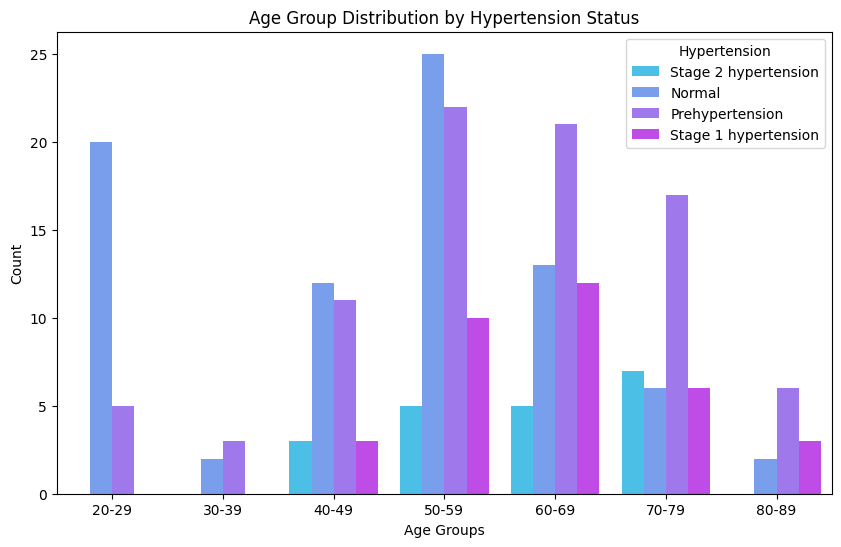

In [43]:
#Hypertension Rates with Age groups Distribution Plot
bins = range(20, 91, 10)
labels = [f'{i}-{i+9}' for i in bins[:-1]]
ppg_bp_df['Age Group'] = pd.cut(ppg_bp_df['Age(year)'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.countplot(data=ppg_bp_df, x='Age Group', hue='Hypertension', palette='cool')
plt.title('Age Group Distribution by Hypertension Status')
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.show()

It is clear from the Age Group Distribution by Hypertension Status that while younger age groups (20-29) generally are in the normal category. Whereas older age groups i.e. 50+ tend to have a higher proportion of hypertension cases, emphasizing age as a risk factor for cardiovascular conditions.

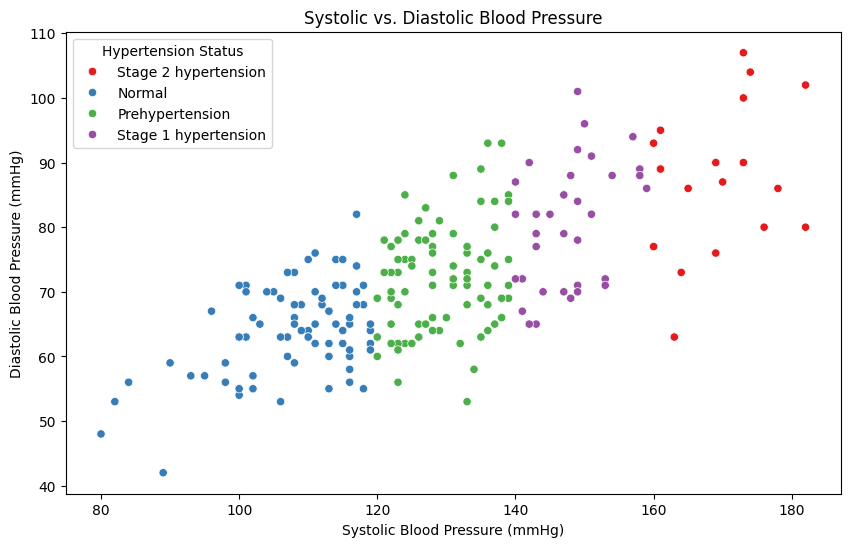

In [16]:
#Systolic vs Diastolic Blood Pressure Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ppg_bp_df, x='Systolic Blood Pressure(mmHg)', y='Diastolic Blood Pressure(mmHg)', hue='Hypertension', palette='Set1')
plt.title('Systolic vs. Diastolic Blood Pressure')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Diastolic Blood Pressure (mmHg)')
plt.legend(title='Hypertension Status')
plt.show()

The Systolic vs. Diastolic Blood Pressure scatterplot shows a positive linear relationship between the two measures. Higher systolic blood pressure is generally accompanied by higher diastolic pressure. Individuals with hypertension are concentrated in the upper range of both systolic and diastolic pressures. This visualization highlights the interdependence of systolic and diastolic blood pressure in diagnosing hypertension.

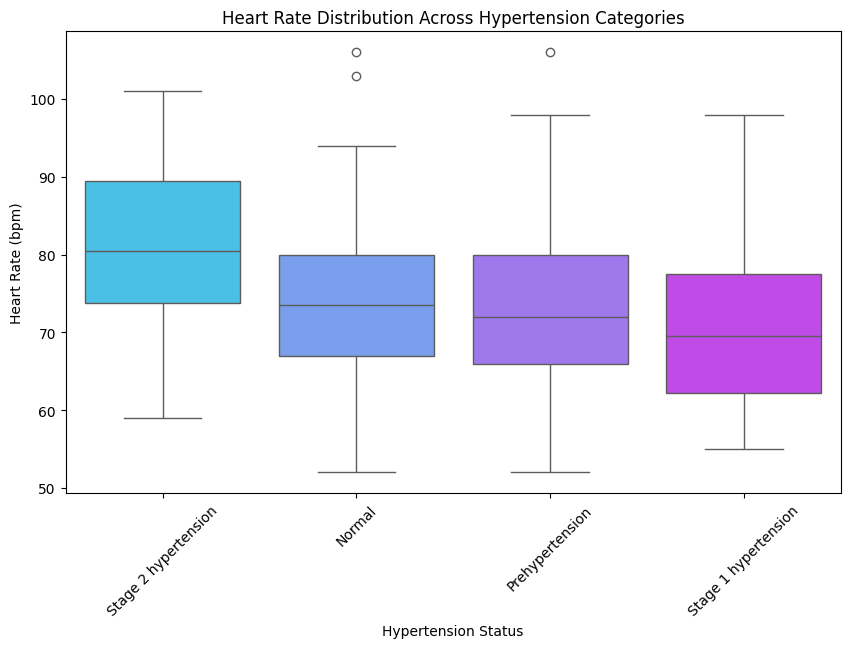

In [45]:
#Heart Rate Across Hypertension Categories Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=ppg_bp_df, x='Hypertension', y='Heart Rate(b/m)', palette='cool', hue='Hypertension', legend=False)
plt.title('Heart Rate Distribution Across Hypertension Categories')
plt.xlabel('Hypertension Status')
plt.ylabel('Heart Rate (bpm)')
plt.xticks(rotation=45)
plt.show()

The Heart Rate Across Hypertension boxplot shows a modest increase in heart rate as hypertension severity increases. Normal and prehypertensive individuals exhibit a relatively lower heart rate, while those with Stage 2 hypertension show slightly higher values. This plot suggests that hypertension may affect heart rate, although it may not be as strong a determinant as other factors like BMI or age.